# **Contrastive Learning for Unpaired Image-to-Image Translation**
https://arxiv.org/pdf/2007.15651v3.pdf



# 0. The paper's key points and takeaways

- GAN on image-to-image learning: keep the content, transfer the appearance/style
- patches 
- contrastive learning
- **patchNCE loss**: multilayer patchwise contrastive loss (allows for training on unaligned data and even single image 'zero-shot' learning)
- the paper's model - presenting all the above features - is called **CUT** (constrative unpaired translation)



## Image-to-image learning

 - image-to-image learning: keep the content, transfer the appearance/style
 - translate images from input domain *X* to appear like
an image from domain *Y* (eg X=horses, Y=zebras) 
- datasets include horse2zebra, apple2orange, monet2photo, cityscapes, grumpifycat
 - the goal is to keep the input image's **content** - it's main structure, shape and rotation, position - (eg. a dog looking from left to right with it's tongue out), but transform it's **style** or appearance according to a target style (eg the dog breed beagle or painting style)
 - this is referred to as the **disentanglement problem**, where the task is to separate style from transfer
 ![](https://drive.google.com/uc?export=view&id=1_MQTt4M_q3TerKY4ek3d6oqdOhG1WoPc)
source: https://arxiv.org/pdf/2007.04964.pdf

### GAN

- the **adversarial loss** coming from the GAN structure ensures the style change: it is basically a two player game of generator (*G*) and discriminator (*D*) where G aims to generate images similar to the target style, while D's goal is to tell apart generated images and real images (which have the target style by default)
 ![](https://drive.google.com/uc?export=view&id=1aTDKZ3ZCXXEWZNGjinfMWATuUA_TWuTd)
- CUT model's generator follows an encoder-decoder structure
  - encoder learns to pay attention to structural similarites of *X* and *Y* domains (object parts and shapes)
- content is traditionally preserved with cycle-consistency ([cycleGAN](https://arxiv.org/pdf/1703.10593.pdf)),  here it is preserved by maximizing the **mutual information** between corresponding input and output **patches**
 

In [5]:
import torch
from torch.autograd import Variable

adv_loss = torch.nn.BCEWithLogitsLoss()
def GAN_loss(prediction, isReal):
  if isReal:
    target_tensor = Variable(torch.cuda.FloatTensor(prediction.size()).fill_(1.0), requires_grad=False)
  else:
    target_tensor = Variable(torch.cuda.FloatTensor(prediction.size()).fill_(0.0), requires_grad=False)
  return adv_loss(prediction, target_tensor)

def compute_D_loss(netD, fake_target, real_target):
  # netD: discriminator network
  # fake_target: generated output in target domain
  # real_target: originally in target domain
  # Fake
  # stop backprop to the generator by detaching fake_B
  fake_target = fake_target.detach()
  pred_fake = netD(fake_target)
  loss_D_fake = GAN_loss(pred_fake, False).mean()
  # Real
  pred_real = netD(real_target)
  loss_D_real = GAN_loss(pred_real, True).mean()

  loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
  return loss_D

#### Problems with cycle consistency

- bijectivity constraint can be too harsh
- computationally more expensive to deal with the 'inverse' (F: Y -> X) as well
- **CUT learns a mapping in one direction only** and avoids using inverse auxiliary generators and discriminators
 ![](https://drive.google.com/uc?export=view&id=1xl79YmC-_HKASgYWLhZzEcSkxsv6WgXo)

## Patches

- not only the whole image but also **corresponding patches should also preserve content**

- "*given a patch showing the legs of an output zebra, one should be able to more strongly associate it to the corresponding legs of the input horse, more so than the other patches of the horse image*"

 ![](https://drive.google.com/uc?export=view&id=1Q8AaQe0--giKfuJqGcdbZFif8oW0daPF)


## Contrastive learning

- contrastive learning: learn similar/dissimilar representations to be able to **contrast** between similar and dissimilar things
- encoder architecture: to convert the image into representations 
- associating corresponding patches to each other, while disassociating them
from others
  - given a 'query' patch *x* with a zebra's legs, a positive sample is *x+* with a horse's leg, while there are lots of *x-* negative samples eg. horse's head, horse's back, background
- InfoNCE (Noise-Contrastive Estimation) is a variant of contrastive loss function from the paper [Representation Learning with Contrastive Predictive Coding](https://arxiv.org/pdf/1807.03748.pdf)
  - it is the categorical cross-entropy of classifying the positive sample correctly over the negative samples
  - v, v+, v- are the encoded representations of x, x+ and x- rescpectively 
  - τ is a temperature parameter set to 0.07
 ![](https://drive.google.com/uc?export=view&id=1zmr24oGl1P7K4a6jox-UWoTcCTCrt_bH)





## PatchNCE loss: multi-layer, patchwise contrastive loss

- use several layers of the encoder not only the output layer
- deeper layers corresponding to bigger patches
- select L layers of interest and pass the feature maps through a small **two-layer MLP network**, *H*

 ![](https://drive.google.com/uc?export=view&id=1xDUssPrQTZ5NNs78CLgO9jD7Bp8_nTws)

 ### PatchNCE 
 - buildong upon InfoNCE

  ![](https://drive.google.com/uc?export=view&id=1WXXg3lqp7tl1ZIbO0IqIjy4E8eUH_6BM)
 - the three types of *z*'s are the features representing pathces
  - from *l*th encoder layer 
  - in the output image, in its positive sample and in negative samples, respectively (coming from the input image)
 - *H* is the two-layer MLP, *S* is the set of available patches *within* the input image

In [4]:
import torch
cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
def PatchNCELoss(feat_q, feat_s, tau=0.07):
  # feat_q: encoded input's query features at sampled locations (B x C x S)
  # feat_s: encoded output's features at sampled locations (B x C x S)
  # tau: temperature for patchNCEloss
  # B: batch size, C: channel size, S: number of sample locations

  B, C, S = feat_q.shape
  # pos logit
  BS = B*S
  l_pos = torch.bmm(feat_q.view(BS, 1, -1), feat_s.view(BS, -1, 1)) # (B*S) x 1 x C,  (B*S) x C x 1
  l_pos = l_pos.view(BS, 1) # (B*S) x 1 
  # neg logit
  l_neg = torch.bmm(feat_q.transpose(1, 2), feat_s) # B x S x S =  (B x S X C) * (B x C X S)
  # diagonal entries are meaningless
  diagonal = torch.eye(S)[None, :, :]
  l_neg.masked_fill_(diagonal, -float('inf'))
  l_neg = l_neg.view(-1, S)
  out = torch.cat((l_pos, l_neg), dim=1) / tau #  (B*S) x (S+1)
  loss = cross_entropy_loss(out, torch.zeros(out.size(0)))
  return loss

 ![](https://drive.google.com/uc?export=view&id=1NM5ebFyASwgLqkMx6YBOzsYwADfmrWt_)


### Overall Loss
- third term of loss uses samples from the target domain *Y*, so basically it is an identity loss
- CUT model: weight of last two terms are ones
- FastCUT model: identity loss is ignored, weight of second term is 10
 ![](https://drive.google.com/uc?export=view&id=1kWSzrw0LU9a3Tf0TBZoscRMy6mN2Hh3V)


In [9]:
def compute_G_loss(netD, input, target, lambdaNCE, lambdaNCE_Y):
  # input: input image from domain X
  # target: target image from domain Y
  # netD: discriminator network
  # lambdaNCE: weight of PatchNCE loss (within input)
  # lambdaNCE_Y: weight of PatchNCE_Y loss (in Y domain)
  fake = netG(input)
  pred_fake = netD(fake)
  loss_G_GAN = GAN_loss(pred_fake, True).mean()
  loss_NCE = self.calculate_NCE_loss(input, fake) * lambdaNCE
  if lambdaNCE_Y > 0.0:
      loss_NCE_Y = self.calculate_NCE_loss(target, netG(target)) *lambdaNCE_Y
      return loss_G_GAN + loss_NCE + loss_NCE_Y
  else:
      return loss_G_GAN + loss_NCE 

## Single image learning

- the method can operate even when *X* and *Y* only contain a single image each
- due to patchwise contrastive loss (negative patch samples are coming from 
within the image)
- raining only requires a single image from each domain
- this model is called **SinCUT**

 ![](https://drive.google.com/uc?export=view&id=1UwOYFZ7X8Uw39fj-KGW35GAv8zhz9RiI)


# 1. Visualize losses

In [23]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

def process_log(path):
  losses = defaultdict(list)
  file = open(path, 'r')
  for line in file:
    if line.find('epoch:') == -1:
      continue
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.replace(',', '')
    line = line.replace(':', '')
    parts = line.strip().split(' ')
    data = {str(parts[2*i]): float(parts[2*i+1]) for i in range(len(parts)//2)}
    data['epoch'] = int(data['epoch'])
    data['iters'] = int(data['iters'])
    if data['epoch'] not in losses['epoch']:
      for k, v in data.items():
        losses[k].append(v)
  for k, v in losses.items():
    losses[k] = np.array(v)
  return losses

losses = process_log('loss_log_grumpycat_CUT_400.txt')
losses.keys()

dict_keys(['epoch', 'iters', 'time', 'data', 'G_GAN', 'D_real', 'D_fake', 'G', 'NCE', 'NCE_Y'])

In [24]:
def plot_two_losses(loss1, loss2, names, title):
  smooth1 = gaussian_filter1d(loss1, sigma=2)
  smooth2 = gaussian_filter1d(loss2, sigma=2)
  plt.plot(smooth1, 'b')
  plt.plot(smooth2, 'r')
  plt.title(title, fontsize=15)
  plt.xlabel('epochs', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.legend(names)
  plt.show()

## Discriminator - Generator losses

As expected, the generator and the discriminator of the GAN work against each other. This can be seen from the loss curves' opposite montonic behaviour: as one curve is increasing, the other one is decreasing.

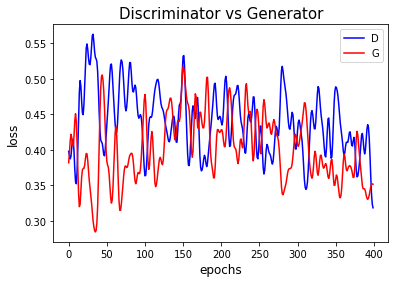

In [37]:
plot_two_losses(losses['D_real']+losses['D_fake'], losses['G_GAN'], ['D', 'G'], 'Discriminator vs Generator')

## Difference between patchNCE on internal and domain samples

In the CUT model two 'types' of contrastive losses (*NCE*, Noise-Contrastive Estimation) contribute to the overall loss next to adversarial loss:
- NCE works with random patches **within the input** as negatives
- NCE_Y, where *Y* denotes the target domain and random patches are taken from this domain('s images)

Intuitively, it is easier to tell apart a random patch from an entirely different image, than a random patch from within the image. This is supported by the lower losses of on domain *Y*.

*Note that FastCUT doesn't leverage NCE_Y, this gives it's fastness.*

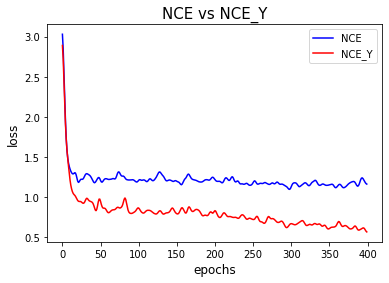

In [27]:
plot_two_losses(losses['NCE'], losses['NCE_Y'], ['NCE', 'NCE_Y'], 'NCE vs NCE_Y')

# 2. Plus

repository changes available at:
https://github.com/Zsaknadrag/contrastive-unpaired-translation

## I. Moving average of losses

loss_mean = 0.999 * loss_mean + 0.001 * current_loss

In [31]:
ma_losses = process_log('loss_log_apple2orange_FastCUT.txt')
ma_losses.keys()

dict_keys(['epoch', 'iters', 'time', 'data', 'G_GAN', 'D_real', 'D_fake', 'G', 'NCE', 'mean_G_GAN', 'mean_D_real', 'mean_D_fake', 'mean_G', 'mean_NCE'])

In [56]:
def plot_loss(loss, title):
  plt.plot(loss)
  plt.title(title, fontsize=15)
  plt.xlabel('epoch', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.show()

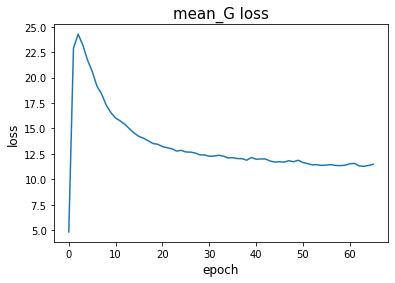

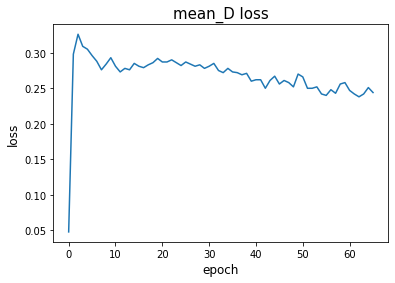

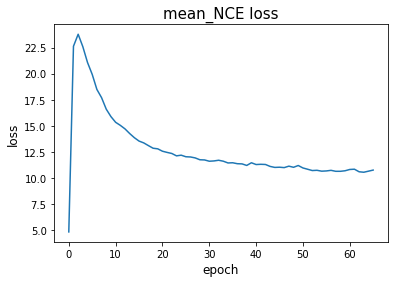

In [59]:
plot_loss(ma_losses['mean_G'], 'mean_G loss')
plot_loss(ma_losses['mean_D_real']+ma_losses['mean_D_fake'], 'mean_D loss')
plot_loss(ma_losses['mean_NCE'], 'mean_NCE loss')

## II. Grayscale transformation

grayscale training option that transforms rgb images to grayscale on the fly

In [14]:
gray_losses = process_log("loss_log_grumpycat_CUT_grayscale_400.txt")
rgb_losses = process_log('loss_log_grumpycat_CUT_400.txt')
gray_losses.keys()

dict_keys(['epoch', 'iters', 'time', 'data', 'G_GAN', 'D_real', 'D_fake', 'G', 'NCE', 'NCE_Y'])

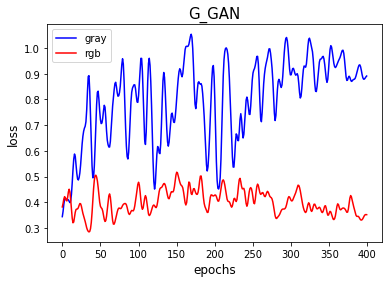

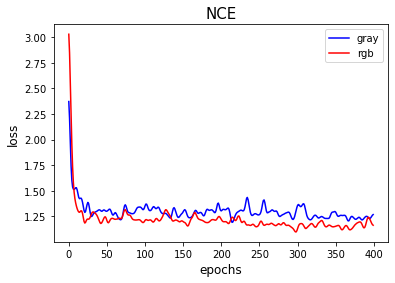

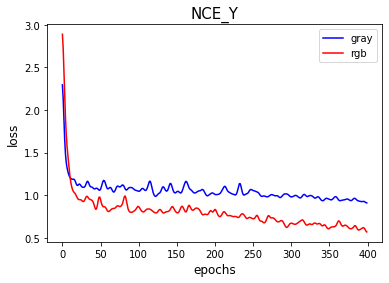

In [20]:
plot_two_losses(gray_losses['G_GAN'], rgb_losses['G_GAN'], ['gray', 'rgb'], 'G_GAN')
plot_two_losses(gray_losses['NCE'], rgb_losses['NCE'], ['gray', 'rgb'], 'NCE')
plot_two_losses(gray_losses['NCE_Y'], rgb_losses['NCE_Y'], ['gray', 'rgb'], 'NCE_Y')

Based on the losses more tuning is needed for grayscale training, to approximate rgb training behaviour.